# Title

#### Predictive Modelling of Subscribers in Plaicraft

# Introduction
A research group is collecting data about how people play video games. They have set up a MineCraft server, and players’ actions are recorded as they navigate through the world. For running this project, they need to target their recruitment efforts, and make sure they have enough resources to handle the number of players they attract. The purpose of our project is to provide an idea for this and use data analysis to prove whether this idea can effectively assist their recruitment.

Understanding how players interact with a game environment is essential for improving recruitment strategies, managing server resources, and designing engaging gameplay experiences. For example, newsletter subscription can serve as a meaningful indicator of player engagement and long-term interest. Players who subscribe may be more invested in game updates, community events, or new content, and identifying the characteristics of these players can support more effective recruitment and communication strategies.

In this project, we focus on two predictors available in the player dataset—**age and total play time**—and examine whether these variables can be used to predict newsletter subscription status. Our research question is therefore:

**Can a player's age and play time be used to predict whether or not they are subscribed to a game-related newsletter?**

This relates to broad question 1 which we will answer in our discussion:

**What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

To investigate this, we clean and summarize the `players.csv` dataset, explore the relationships between age, play time, and subscription, and build a predictive classification model using K-Nearest Neighbours (KNN). The results allow us to evaluate how well these behavioural and demographic attributes distinguish between subscribed and non-subscribed players, and to assess their usefulness for informing future recruitment strategies.

In [14]:
# Load the required libraries
library(tidyverse)
library(tidymodels)

# Read the Data
players <- read_csv("https://raw.githubusercontent.com/achan919/dsci-final-project/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


# Data Description
The file `players.csv` was collected by a research group in Computer Science at UBC to help us complete our project. It contains 196 players’ information and 7 variables columns:

| Variable     |Data Type | Description |
|--------------|----------|-------------|
| experience   | chr |Level of experience (Pro, Veteran, Amateur, Regular, Beginner) |
| subscribe    | lgl |Whether the player subscribed to the newsletter |
| hashedEmail  | chr | Hashed/hidden email of the player |
| played_hours | dbl |Total hours played (mean = 5.846) |
| name         | chr |Player's first name |
| gender       | chr |Gender (Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other) |
| Age          | dbl |Player age in years (mean = 21.14) |

# Methods & Results

### **1. Wrangling + Cleaning**

In the players.csv data set, each row in the dataset represents a unique player. For our predictive analysis, we exclusively use this data set because we only need to focus on three key variables relevant to our research question: **Age, played_hours, and subscribe**. Since the `subscribe` variable was originally stored as a logical type (TRUE/FALSE), we converted it into a categorical factor with descriptive labels (“Subscribed” and “Not Subscribed”). This improves interpretability and ensures proper handling during visualization and modeling.

The dataset contained two missing values in the `Age` variable. Because KNN cannot operate on missing predictor values, we removed these rows to maintain a clean and fully usable dataset.

In [2]:
# Tidy the players data set: give more descriptive labels and discard two rows which lack of 
players_tidy <- players |>
select(Age, played_hours, subscribe) |>
  mutate(subscribe = factor(subscribe,  
                            levels = c(FALSE, TRUE), 
                            labels = c("Not Subscribed", "Subscribed"))) |>
 filter(!is.na(Age))
head(players_tidy)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,Subscribed
17,3.8,Subscribed
17,0.0,Not Subscribed
21,0.7,Subscribed
21,0.1,Subscribed
17,0.0,Subscribed


### **2. Exploratory Data Analysis**

Before conducting predictive modeling, we performed exploratory data analysis (EDA) to better understand the distribution of the key variables. We summarized the data using the summary function, allowing us to see the means, medians, max, and mins of the numerical variables. It also allowed us to see the counts for the categorical variable, in this case, subscription status. To identify the most common age groups among players, we aggregated the data by age and extracted the ten most frequent age values. Then we filtered the player dataset to keep only observations belonging to these top age groups, which allowed us to visualize the age distribution more clearly.

In [18]:
# Summary of player dataset
players_summary <- summary(players_tidy)
players_summary

# Summarize player counts by age and extract the top 10 most frequent ages
top10_age_distribution <- players_tidy |>
  group_by(Age) |>
    summarize(
        count = n()) |>
  slice_max(count , n = 10)
top10_age_distribution

players_top10 <- players_tidy |>
  semi_join(top10_age_distribution, by = "Age")

      Age         played_hours              subscribe  
 Min.   : 9.00   Min.   :  0.000   Not Subscribed: 52  
 1st Qu.:17.00   1st Qu.:  0.000   Subscribed    :142  
 Median :19.00   Median :  0.100                       
 Mean   :21.14   Mean   :  5.905                       
 3rd Qu.:22.75   3rd Qu.:  0.600                       
 Max.   :58.00   Max.   :223.100                       

Age,count
<dbl>,<int>
17,73
21,18
22,15
20,14
23,13
24,10
18,7
19,7
26,4


### **3. Visualizations**

6 visualizations of bar graphs are used and are produced by the ggplot function. The first 3 help visualize the distributions of total players that were already shown earlier, the fourth and fifth one show the distribution of age and play time by subscription, and the final one allows us to determine the K used for our prediction. 

#### Visualization 1: Age Distribution

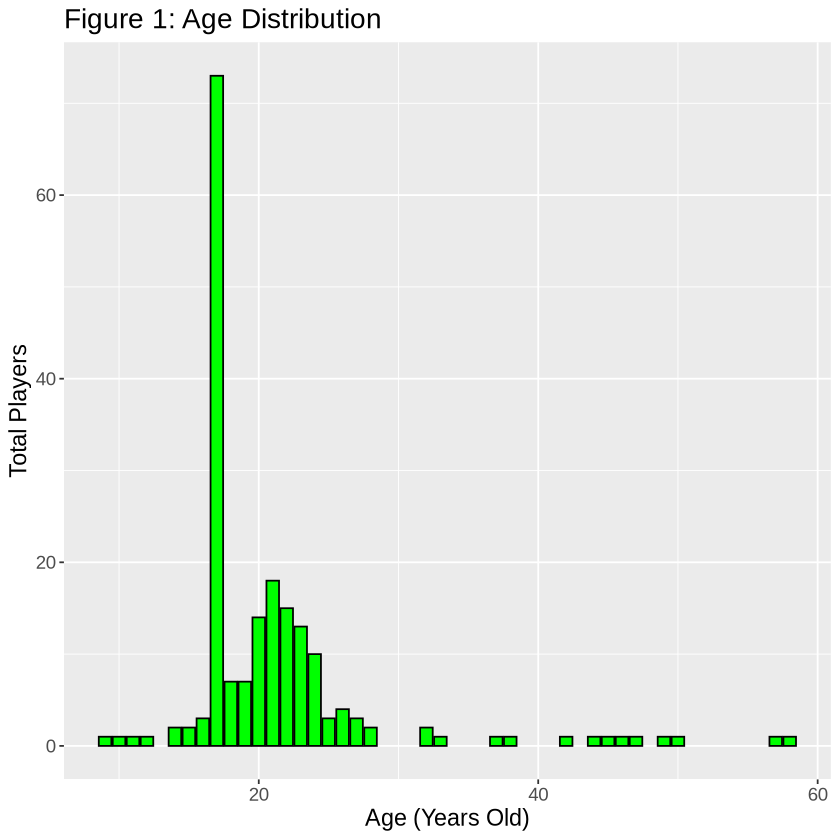

In [4]:
# visualization of age distribution
age_distribution_plot <- players_tidy |>
  ggplot(aes(x = Age)) +
  geom_bar(fill = "green", color = "black") +
  labs(title = "Figure 1: Age Distribution",
       x = "Age (Years Old)",
       y = "Total Players") +
  theme(text = element_text(size = 14))
age_distribution_plot

 #### Visualization 2: Played Hours Distribution

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


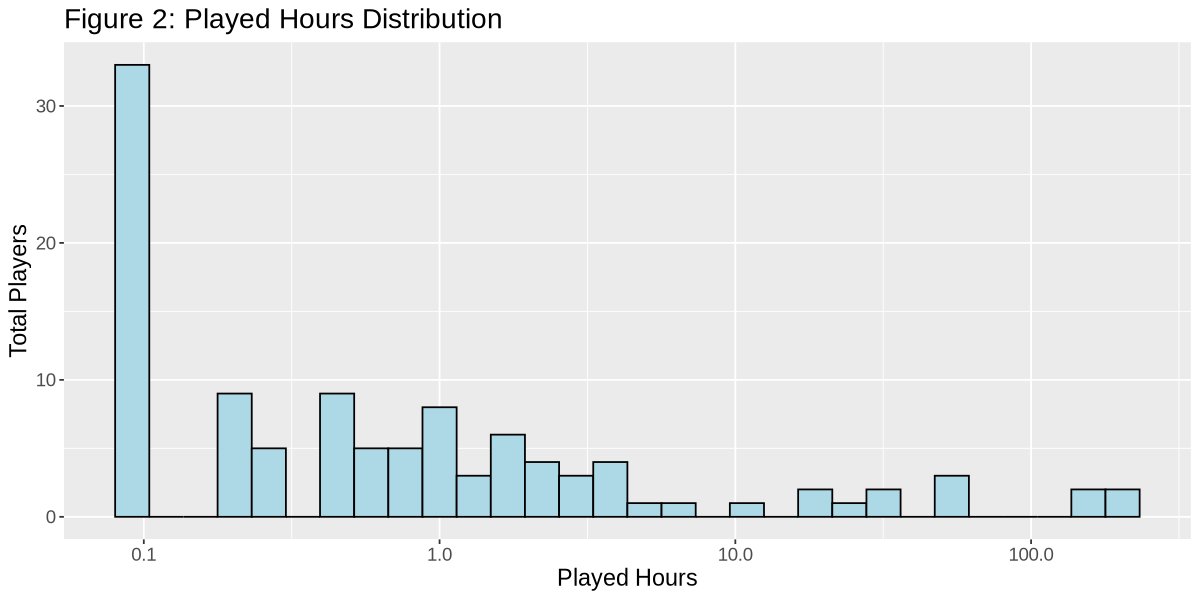

In [5]:
# visualization of played hours distribution
options(repr.plot.width = 10, repr.plot.height = 5) 

played_hours_distribution_plot <- ggplot(players_tidy, aes(x = played_hours)) +
    geom_histogram(fill = "lightblue", color = "black") +
    labs(title = "Figure 2: Played Hours Distribution",
         x = "Played Hours",
         y = "Total Players") +
  scale_x_log10() +
  theme(text = element_text(size = 14))
played_hours_distribution_plot

 #### Visualization 3: Subscription Distribution

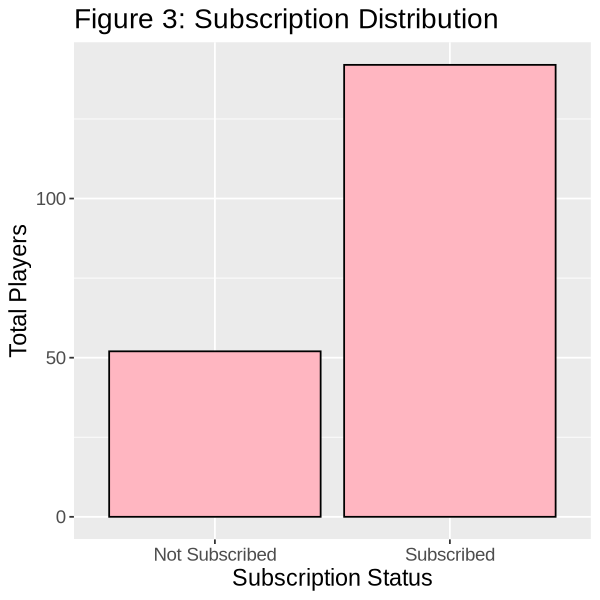

In [6]:
# visualization of subscription distribution
options(repr.plot.width = 5, repr.plot.height = 5) 

subscription_distribution_plot <- players_tidy |>
  ggplot(aes(x = subscribe)) +
  geom_bar(fill = "lightpink", color = "black") +
  labs(title = "Figure 3: Subscription Distribution",
       x = "Subscription Status",
       y = "Total Players") +
  theme(text = element_text(size = 14))
subscription_distribution_plot

#### Visualization 4: A Player's Play Time By Subscription

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


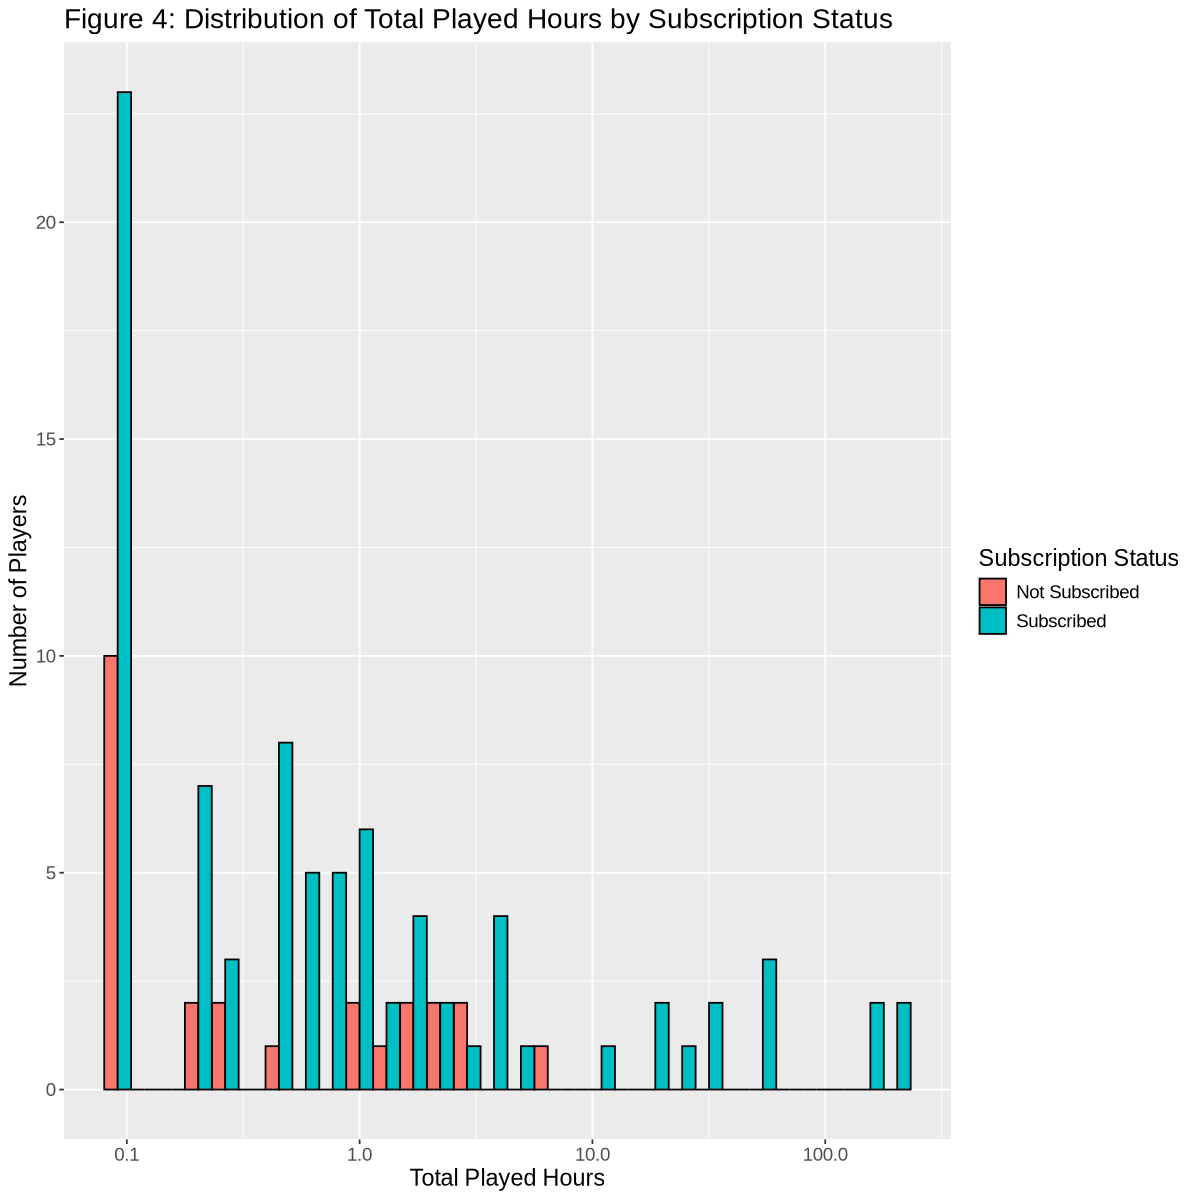

In [15]:
# visualization of player's play time distribution by subscription staus
options (repr.plot.width = 10, repr.plot.height = 10)

total_played_hours_plot <- ggplot(players_tidy, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(color = "black", position = "dodge") +
  scale_x_log10() +
  labs(
    title = "Figure 4: Distribution of Total Played Hours by Subscription Status",
    x = "Total Played Hours",
    y = "Number of Players", 
    fill = "Subscription Status"
  )  +
  theme(text = element_text(size = 14))
total_played_hours_plot

#### Visualization 5: A Player's Age by Subscription

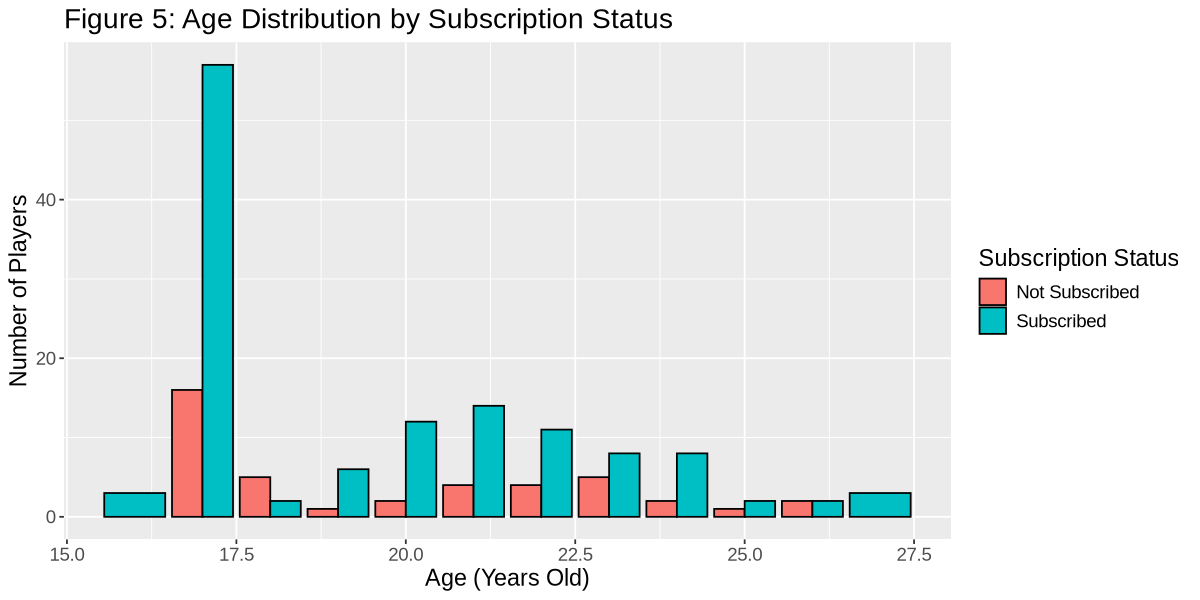

In [16]:
options (repr.plot.width = 10, repr.plot.height = 5)

# visualization of player's age distribution by subscription staus
age_plot <- ggplot(players_top10, aes(x = Age, fill = subscribe)) +
  geom_bar(color = "black", position = "dodge") +
  labs(
    title = "Figure 5: Age Distribution by Subscription Status",
    x = "Age (Years Old)",
    y = "Number of Players",
    fill = "Subscription Status"
  ) +
  theme(text = element_text(size = 14))
age_plot

In order to see whether age and played hours can predict whether a player is subscribed or not, a KNN classification model was created as we are predicting a categorical variable. We started by splitting our data into 75% training and 25% testing data. Afterwards, we coded the model, and since we did not know the ideal K value, we decided to use cross-validation to find the ideal K. A recipe was created and the predictors were then all scaled in order to ensure that all the predictors were treated equally so there was no bias. After performing cross-validation, we found out that the ideal k was 9, as it had the highest accuracy. Once we determined k, we adjusted our classification model and created a new workflow to fit the training data. Next, the model was finally tested on the testing data to give us the accuract, precision, and recall.

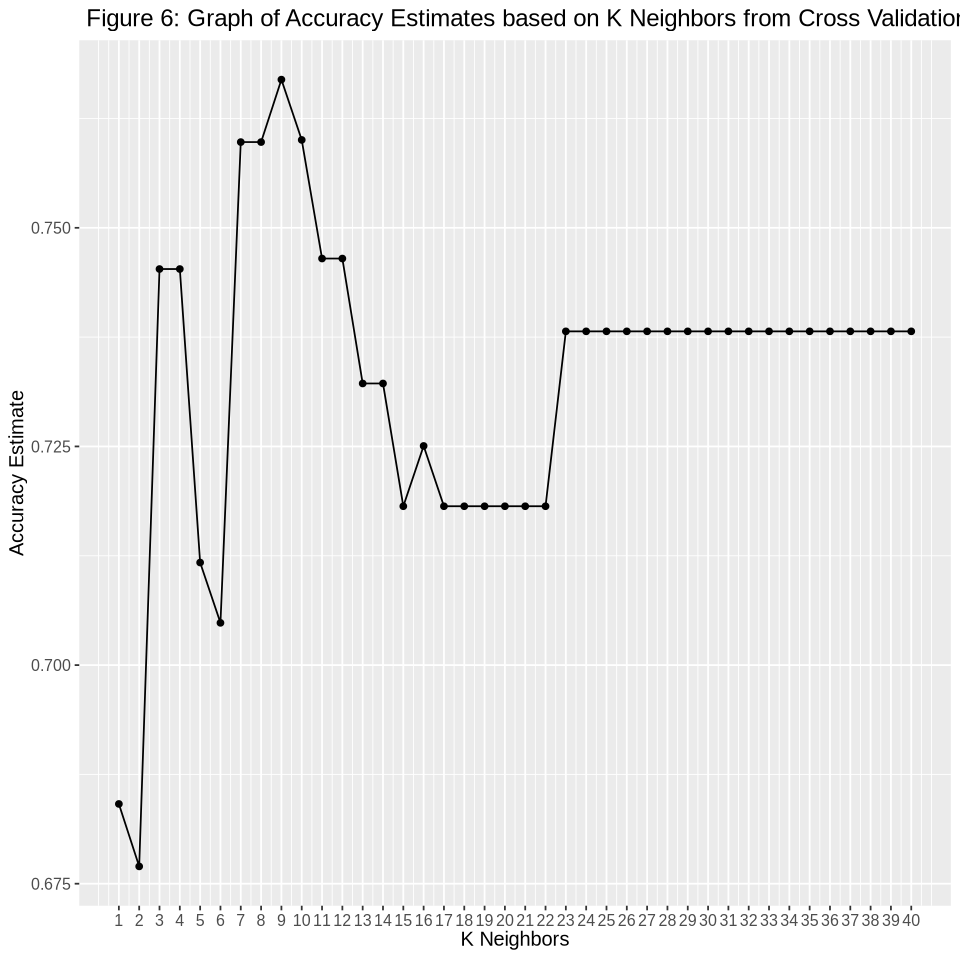

In [22]:
# Make sure the results are reproducible
set.seed(67) 

# Split the data into training set(75%) and testing set(25%)
initial_split <- initial_split(players_tidy, prop = 0.75)
training_data <- training(initial_split)
testing_data <- testing(initial_split)

# Define the knn model specification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a data preprocessing recipe
players_recipe <- recipe(subscribe ~ played_hours + Age, data = training_data) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

# Create 5-fold cross-validation objects, stratified by subscription status
players_vfold <- vfold_cv(training_data, v = 5, strata = subscribe)

# Create the possible K value that will be applied to the model
k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

# Cross-validation tuning using workflows
players_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

# Filter out the accuracy
accuracies <- players_results |>
    filter(.metric == "accuracy")

options(repr.plot.width = 8, repr.plot.height = 8)

#Visualize the cross-validation accuracy
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous (breaks = seq (1, 40, by = 1)) + 
    labs(x = "K Neighbors", y = "Accuracy Estimate") +
    ggtitle(" Figure 6: Graph of Accuracy Estimates based on K Neighbors from Cross Validation") +
    theme(text = element_text(size = 12))

cross_val_plot


In [23]:
# According to the result of the cross-validation, we choose 9 as our K value 
# since it has the highest accuracy

# Redefine the KNN model specification using the best K value 9
players_spec_neighbour <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
set_engine("kknn") |>
set_mode("classification")

# Using workflow to train the final model
players_new_result <- workflow() |>
add_model(players_spec_neighbour) |>
add_recipe(players_recipe) |>
fit(training_data)

In [24]:
# Apply the trained model on the testing set to make predictions
predictions <- predict(players_new_result, testing_data) |>
bind_cols(testing_data)

# Compute the performance metrics of the model on the test set
pred_metrics <- predictions |>
metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")

predictions
pred_metrics

.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
Subscribed,21,0.1,Subscribed
Subscribed,21,0.0,Not Subscribed
Subscribed,22,0.2,Subscribed
Not Subscribed,58,0.3,Subscribed
Subscribed,21,0.7,Subscribed
Subscribed,17,0.0,Subscribed
Subscribed,23,0.0,Not Subscribed
Not Subscribed,18,0.1,Not Subscribed
Subscribed,33,0.0,Not Subscribed


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


In [25]:
# Creating the confusion matrix
players_conf_mat <- predictions |>
conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat

                Truth
Prediction       Not Subscribed Subscribed
  Not Subscribed              3          2
  Subscribed                 11         33

| The four quadrants | Abbreviation | Value |                     Description                                |
|--------------------|--------------|-------|----------------------------------------------------------------|
|   True positive    |      TP      |   33  | The model correctly predicts the players who subscribe         |
|   True negative    |      TN      |   3   | The model correctly predicts players who do not subscribe      |
|   False Positive   |      FP      |   11  | Model incorrectly predicts unsubscribed player as subscribed   |
|   False Negative   |      FN      |   2   | Model incorrectly predicts subscribing players as unsubscribing|

#### **Precision** 
**Definition**: The proportion of all samples predicted to be positive that are actually positive.

**Interpretation**: Of all players the model predicts will subscribe, precision tells us the percentage that truly do subscribe.

#### **Recall**
**Definition**: The proportion of all samples that are actually positive that are correctly predicted to be positive.
**Interpretation**: Of all players who actually subscribe, recall tells us the percentage that the model correctly identifies as subscribers.

In [26]:
# Calculate the precision and recall (based on the confusion matrix above)

# The formula is: Precision = True Positive / (False Positive + True Positive)
precision <- round(33 / (11 + 33), 2)
precision

# The formula is: Recall = True Positive / (False Negative + True Positive)
recall <- round(33 / (2 + 33), 2)
recall

[1] 0.75

[1] 0.94

# Discussion

Our analysis examined whether a player’s age and total play time could be used to predict newsletter subscription status. We initially expected that teenagers would exhibit the highest total play time, because of their greater free time and stronger engagement with online games. Based on this assumption, we anticipated that younger, high-engagement players would also be more likely to subscribe to the game-related newsletter. Our exploratory visualizations present the following patterns: 

Figure 1 shows that the age distribution in our dataset is highly concentrated among players aged 15–25, with very few older participants. The dataset therefore represents a predominantly young gaming population. This uneven age distribution is important to note because it affects how age contributes to predicting subscription status. Since there is limited information from older players, the model will have less data to understand how age affects subscription behaviour for that group. 


Figure 2 shows that total play time is heavily left-skewed: most players have relatively low play hours, while a small number of players accumulate very high play times. This suggests that play time varies widely across users and it may be an important carrier of predictive values for subscription status. This is because there is a high likelihood that high-engagement players would be subscribed, compared to low-engagement players.


Figure 3 highlights that subscription status is imbalanced: most players in the dataset are subscribed. The imbalance between subscribed and non-subscribed groups is important for modeling because predictive algorithms are more biased towards the majority class, meaning that there may be reduced accuracy for the non-subscribed group (the minority).


In Figure 4, we are trying to find a correlation between a player’s total play time and their subscription status. We expected that the more play time a player has, the higher chance that they will be subscribed. In this visualization, we can see it demonstrates a clearer behavioral trend that matches our assumption: subscribed players tend to have higher total play time compared to non-subscribers. At the end of the bar graph, we can see that the highest play time players are subscribed and none of them are not, showing that there is a relationship. The subscribed group suggests a potential positive relationship between engagement and newsletter subscription. This supports using play time as a predictor in the classification model. Additionally, the highest number of subscribers are players who played around 0.1 hours. In conclusion, one assumption we can make is that the players who played a few hours are subscribing to become better and more engaged.


Figure 5, which focuses on the most common age groups, indicates that subscribed players appear more concentrated in certain age ranges, particularly among players in their early 20s. This pattern indicates that age may still contribute moderately to subscription prediction—especially within the most represented age groups. Since our dataset is heavily concentrated in the ages ~17 - 23, we decided to use this range of data as our main basis as it will not be able to capture patterns well for older players because of the lack of data. 


Visualization 4 and 5 together justify the use of age and played hours as predictors in our KNN classification model: play time shows clear separation between subscribed and non-subscribed groups, while age helps capture additional variability within the dominant demographic range. Additionally, when looking at the trends, player characteristics and behaviours differ between player types. It seems that all players no matter the play time can be subscribed, from high play time being exclusively subscribed, to even if there is basically 0 play time. This may show that these players still have a desire to improve or stay connected to the game. This suggests that engagement level has a strong influence on subscription behaviour. When it comes to age, although we will use age as a predictor for our model for this reason, its reliability should be noted because of the limited age distribution in the data set. Ultimately, the exploratory analysis shows that play time is our strongest predictor, supports our modelling choices, and provides context for interpreting the performance of the final classifier.


As we go on to Figure 6, it shows the accuracy measurements from the cross-validation of different k-values based on the K-nearest neighbours (KNN) model. By using this graph, we can choose the best k value to use, which is K = 9 because it produces the highest classification accuracy. To further confirm this decision, we extended the range of K values to make sure that the accuracy reaches a plateau to show that the accuracy cannot be even higher. Afterwards, we were able to refit the model using K = 9 to calculate the precision and accuracy.


When we were done applying the KNN classification mode, we found out that our precision was 75%, the accuracy was 73%, and our recall was 94%. Although both the precision and accuracy are pretty moderate, the recall was very strong. This shows that the model did a good job identifying most subscribers, although it tended to over-predict positive cases, resulting in 11 false positives. For this study, there are 142 subscribed and 52 not subscribed in total. This turns out to be around 73% subscribed and 27% not subscribed. The imbalance between classes makes our KNN model acceptable for the purpose of this study, which aimed to explore whether age and play time could predict subscription status. When comparing our overall accuracy,  73% is similar to the baseline accuracy expected from the imbalance dataset. This means that while this model does have some struggle determining non-subscribers, it was still able to capture the general trend making it tolerable in a non-high-stakes environment. 


Subscription status can be a very valuable asset for researchers to better understand and engage with players over time. By identifying patterns in age and play time that show a higher chance of subscribing, researchers can have a better understanding of who to recruit for future studies. This way, there will be more opportunity for researchers to communicate to newsletter subscribers so that they can achieve their goal of building stronger relationships between players and gathering high-quality data. Although this model shows moderate performance for predicting, it still provides us insight into player behavior, giving the potential to improve player engagement. However, these results can lead to future questions, such as what other factors influence subscription behaviour, or questions like how effective the newsletter is when it comes to engaging with players. All of these questions can play a huge factor in maintaining long-term participation.
